In [1]:
!pip install mlxtend
!pip install scikit-learn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import matplotlib.gridspec as gridspec
import itertools
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
import warnings

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
full_data = pd.read_csv("weatherAUS.csv")

In [ ]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

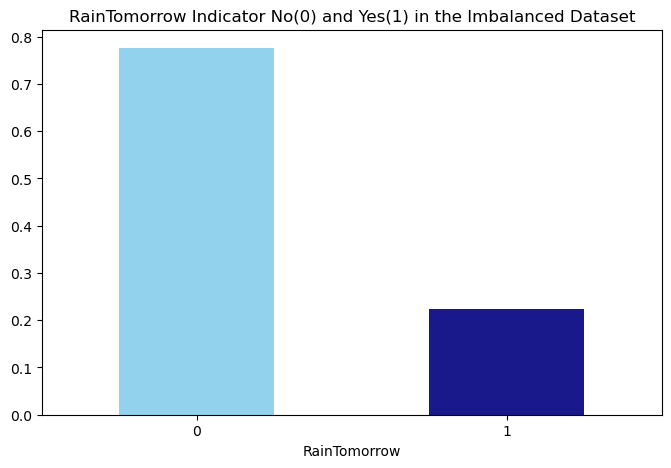

In [ ]:
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

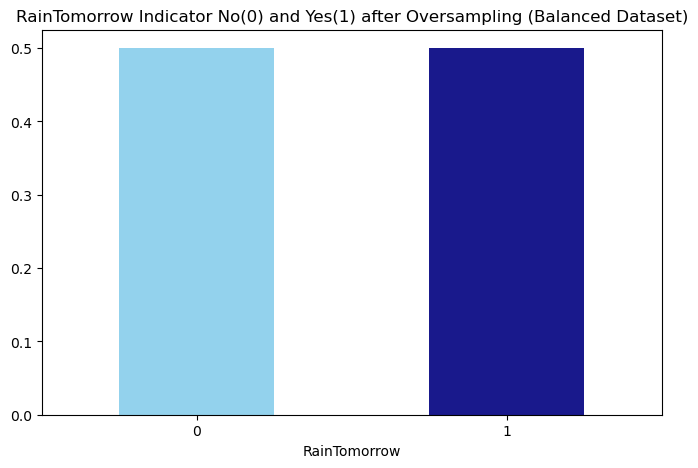

In [ ]:
from sklearn.utils import resample

# Assuming full_data is already defined
no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]

# Oversample the minority class
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)

# Combine the oversampled minority class with the majority class
oversampled = pd.concat([no, yes_oversampled])

# Plot the balanced dataset
fig = plt.figure(figsize=(8, 5))
oversampled.RainTomorrow.value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'navy'], alpha=0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()


<Axes: >

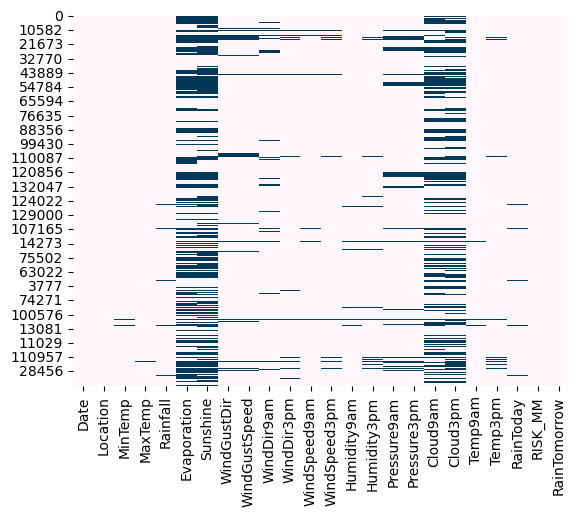

In [ ]:
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [ ]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

Total   Percent
Sunshine     104831  0.475140
Evaporation   95411  0.432444
Cloud3pm      85614  0.388040
Cloud9am      81339  0.368664

In [ ]:
oversampled.select_dtypes(include=['object']).columns


Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [ ]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])


In [ ]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])


In [ ]:
warnings.filterwarnings("ignore")

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

# Use a simpler estimator and reduce the number of iterations
mice_imputer = IterativeImputer(estimator=LinearRegression(), max_iter=5, random_state=0)

# Perform imputation
MiceImputed = oversampled.copy(deep=True)
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [ ]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.118151
Sunshine            5.877605
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.600000
Pressure3pm         8.600000
Cloud9am            4.000000
Cloud3pm            3.628532
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


In [ ]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(156473, 24)

<Axes: >

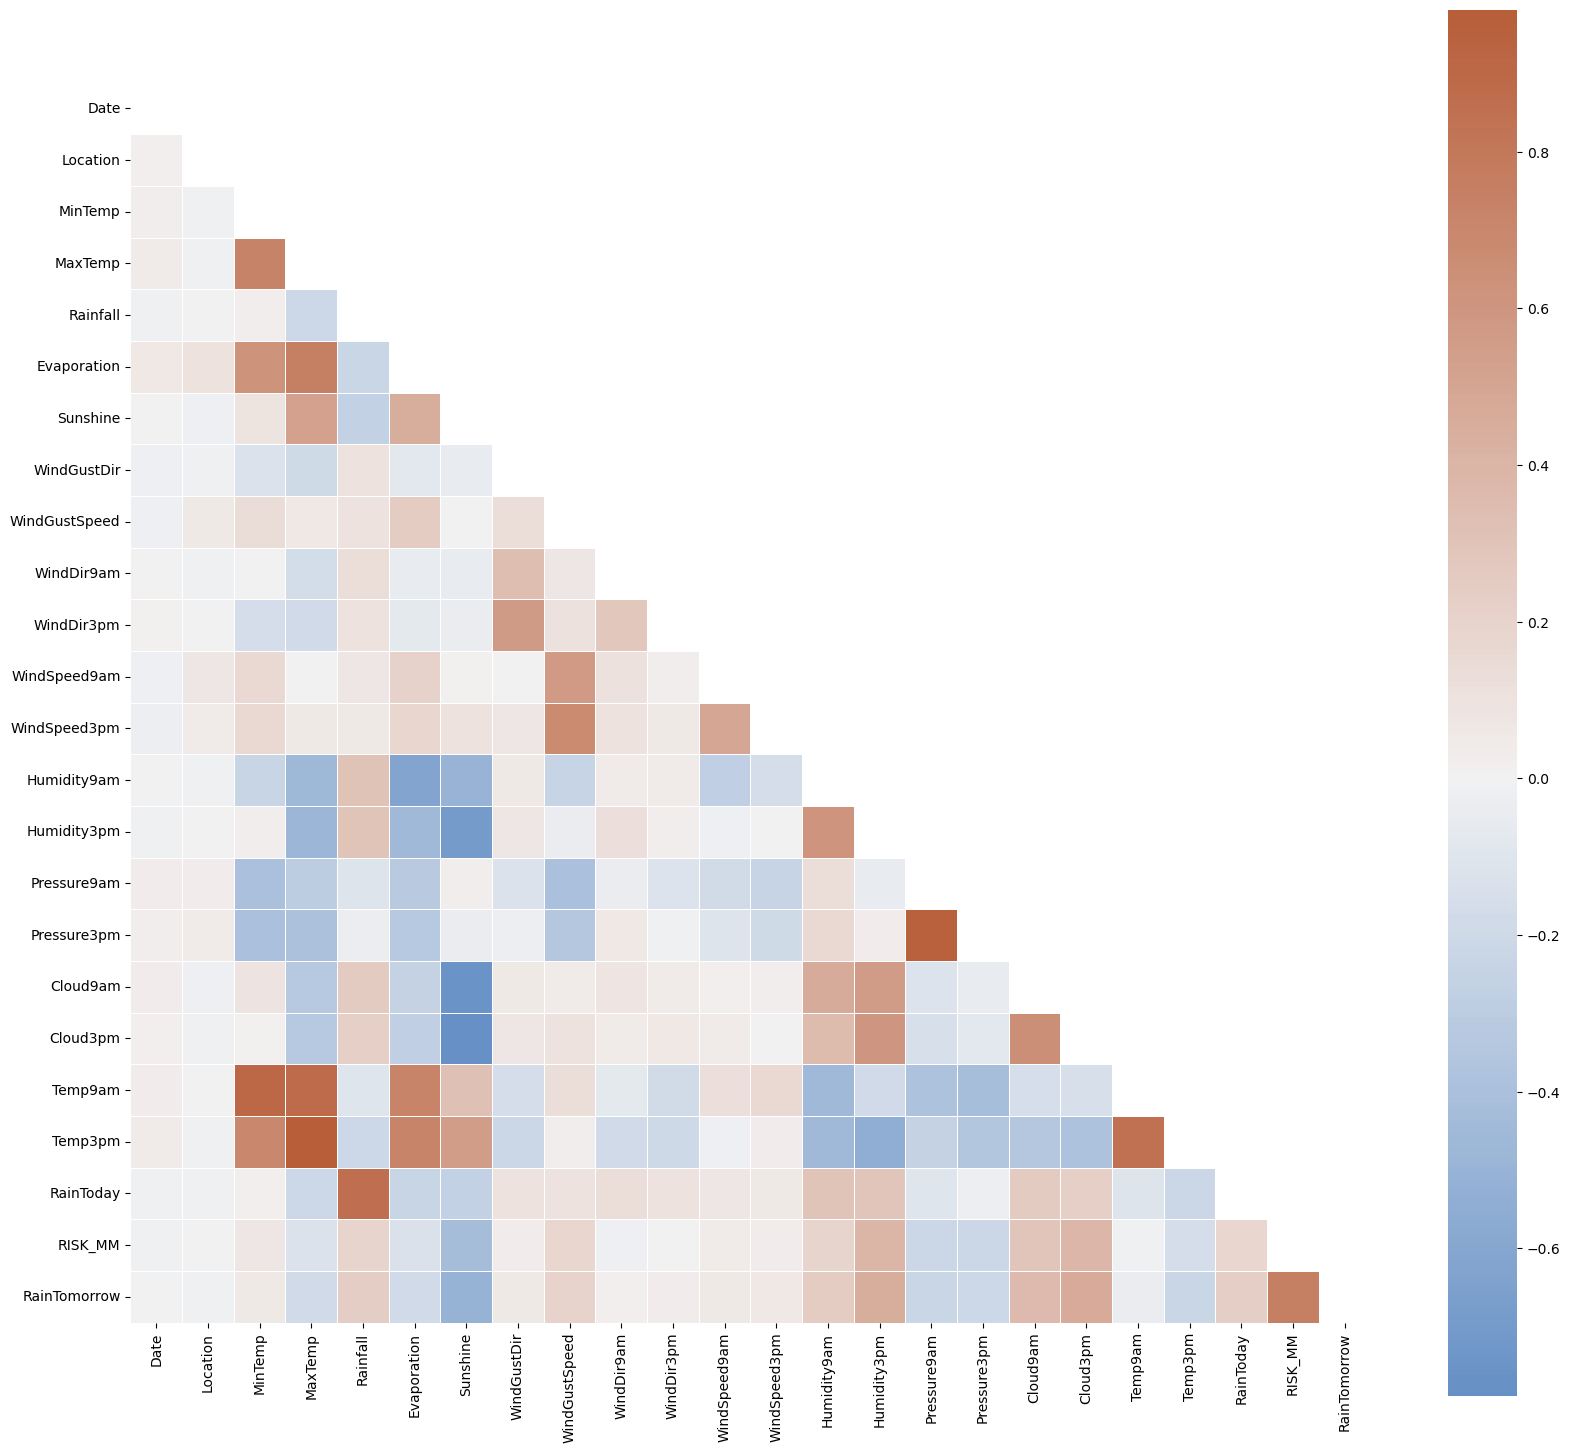

In [ ]:
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

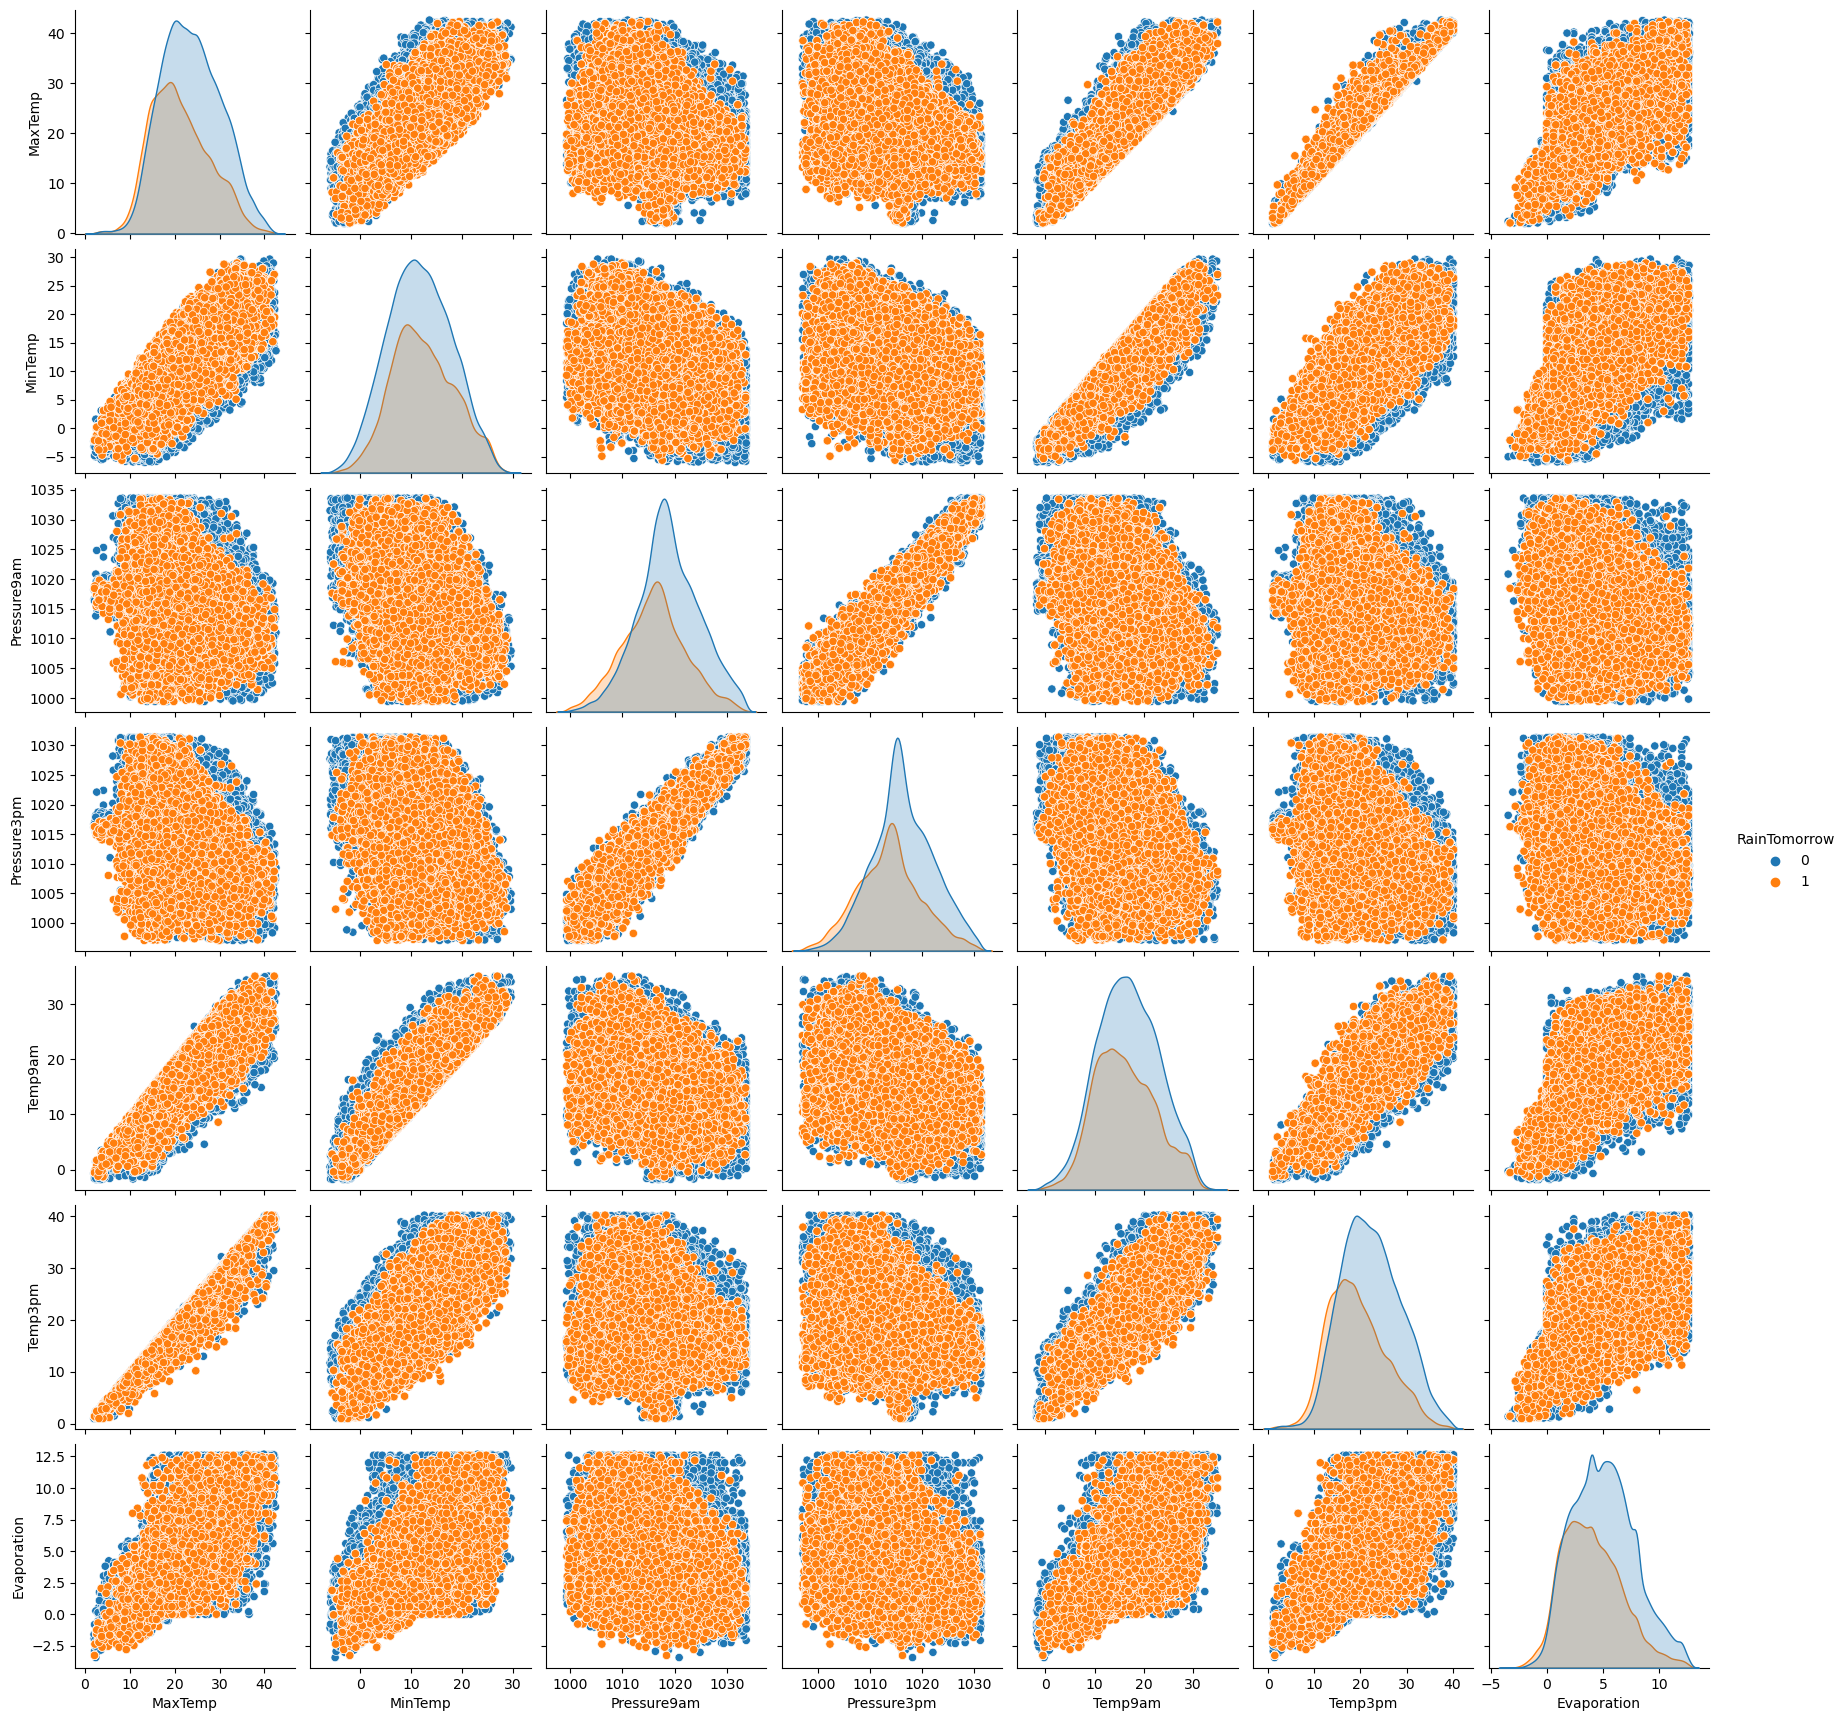

In [ ]:
sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )

In [ ]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)


In [ ]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RISK_MM'],
      dtype='object')


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Cloud3pm', 'RISK_MM']
[0.00233608 0.00257386 0.00291934 0.00401399 0.01072205 0.00267512
 0.06196831 0.00163828 0.00794172 0.0019329  0.00193109 0.00155852
 0.00216162 0.00731007 0.03460588 0.00817436 0.01313512 0.01957172
 0.05306162 0.00311747 0.0057028  0.00398492 0.74696315]


In [ ]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay

def plot_roc_curve(fper, tper, roc_auc):
    plt.figure()
    plt.plot(fper, tper, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0 = time.time()
    
    if not verbose:
        model.fit(X_train, y_train, verbose=0)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time() - t0
    
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test, y_pred, digits=5))
    
    # Plot ROC curve
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    plot_roc_curve(fper, tper, roc_auc)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues, values_format='.2f')
    plt.show()
    
    return model, accuracy, roc_auc, coh_kap, time_taken


Accuracy = 0.7894117947800302
ROC Area under Curve = 0.8634533128481273
Cohen's Kappa = 0.5492969666539416
Time taken = 2.787344217300415
              precision    recall  f1-score   support

           0    0.80702   0.86016   0.83274     23842
           1    0.75677   0.67899   0.71577     15277

    accuracy                        0.78941     39119
   macro avg    0.78189   0.76958   0.77426     39119
weighted avg    0.78739   0.78941   0.78706     39119



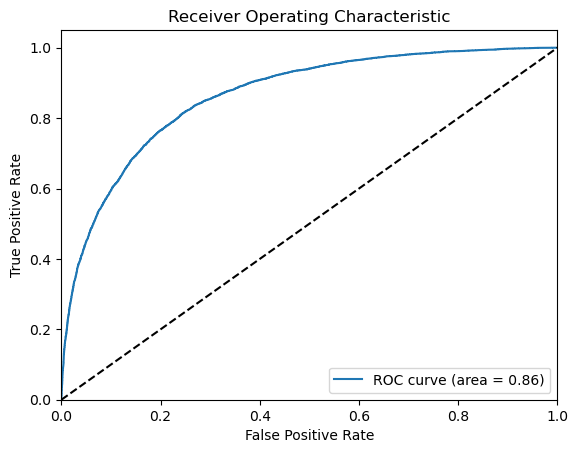

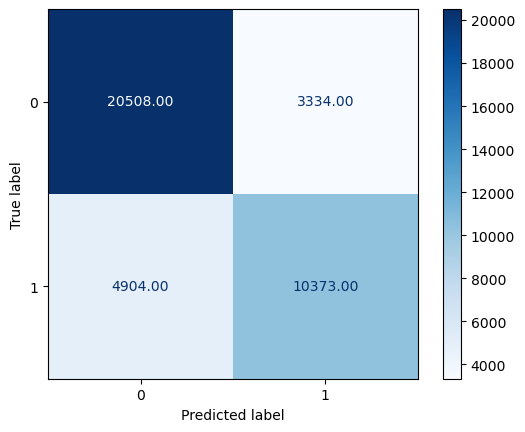

Accuracy = 0.863621258212122
ROC Area under Curve = 0.9018679501718665
Cohen's Kappa = 0.7168676202631982
Time taken = 0.5857772827148438
              precision    recall  f1-score   support

           0    0.90527   0.86696   0.88570     23842
           1    0.80523   0.85841   0.83097     15277

    accuracy                        0.86362     39119
   macro avg    0.85525   0.86269   0.85834     39119
weighted avg    0.86620   0.86362   0.86433     39119



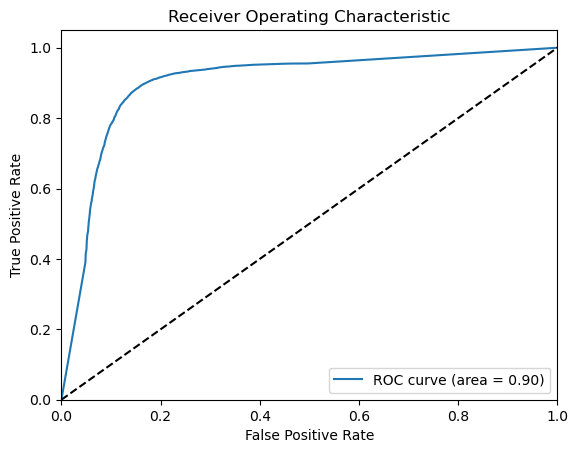

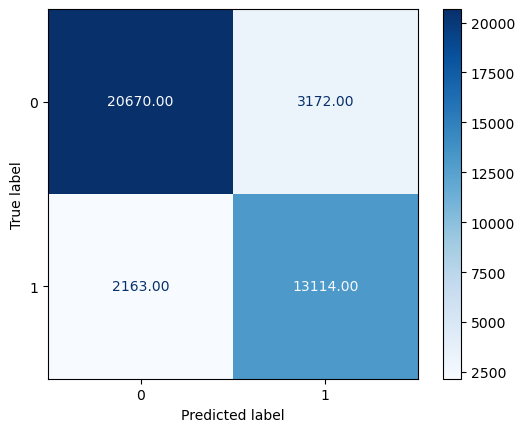

Accuracy = 0.887369309031417
ROC Area under Curve = 0.9584261428869424
Cohen's Kappa = 0.7632292981229015
Time taken = 180.624520778656
              precision    recall  f1-score   support

           0    0.90658   0.90886   0.90772     23842
           1    0.85720   0.85383   0.85551     15277

    accuracy                        0.88737     39119
   macro avg    0.88189   0.88135   0.88161     39119
weighted avg    0.88729   0.88737   0.88733     39119



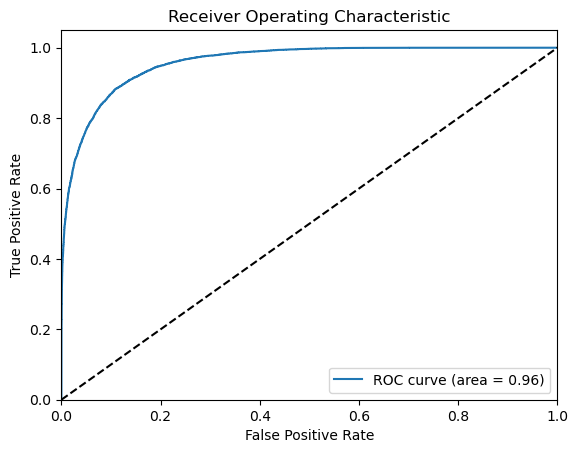

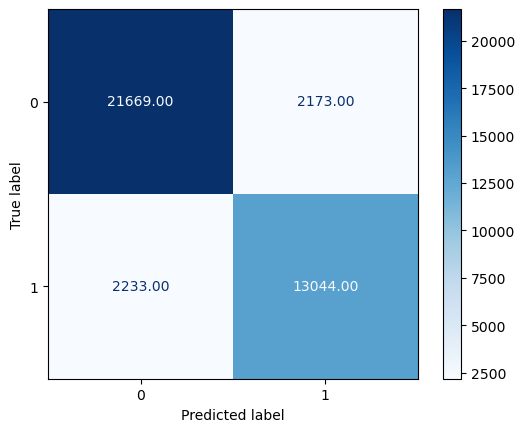

Accuracy = 0.9304174442086965
ROC Area under Curve = 0.9798295730763188
Cohen's Kappa = 0.8544812711681488
Time taken = 45.71453905105591
              precision    recall  f1-score   support

           0    0.95013   0.93490   0.94245     23842
           1    0.90089   0.92341   0.91201     15277

    accuracy                        0.93042     39119
   macro avg    0.92551   0.92916   0.92723     39119
weighted avg    0.93090   0.93042   0.93057     39119



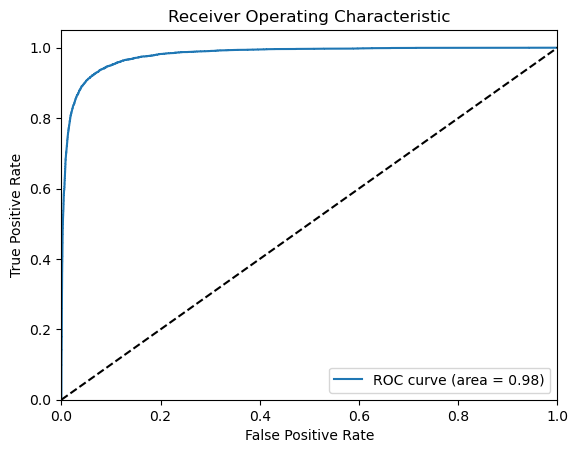

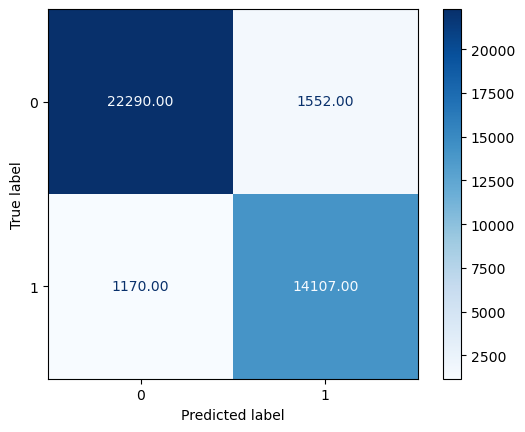

[LightGBM] [Info] Number of positive: 45788, number of negative: 71566
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4314
[LightGBM] [Info] Number of data points in the train set: 117354, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390170 -> initscore=-0.446598
[LightGBM] [Info] Start training from score -0.446598
Accuracy = 0.8610393926225108
ROC Area under Curve = 0.9380644681521068
Cohen's Kappa = 0.7091110266382223
Time taken = 2.322831869125366
              precision    recall  f1-score   support

           0    0.89092   0.87971   0.88528     23842
           1    0.81588   0.83190   0.82382     15277

    accuracy                        0.86104     39119
   macro avg    0.85340   0.85581   0.85455     39119
weighted avg    0.86161   0.86104   0.86128     39119



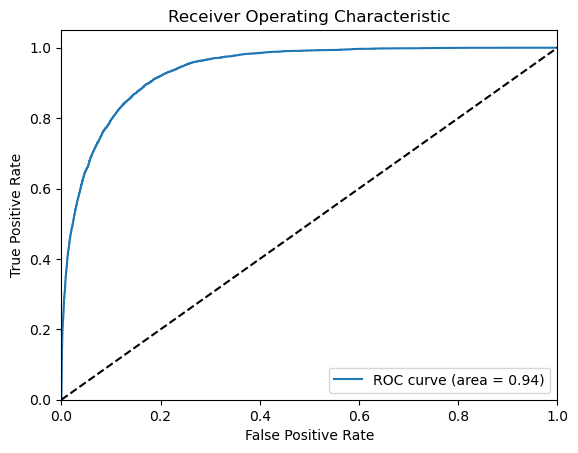

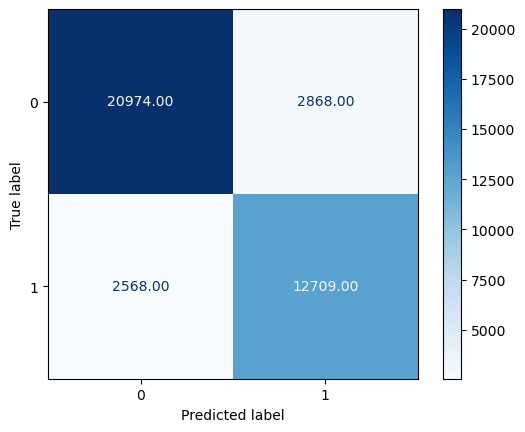

Accuracy = 0.9409749737978987
ROC Area under Curve = 0.9837732660791022
Cohen's Kappa = 0.8779673070092874
Time taken = 236.44262027740479
              precision    recall  f1-score   support

           0    0.97904   0.92291   0.95015     23842
           1    0.88957   0.96917   0.92767     15277

    accuracy                        0.94097     39119
   macro avg    0.93431   0.94604   0.93891     39119
weighted avg    0.94410   0.94097   0.94137     39119



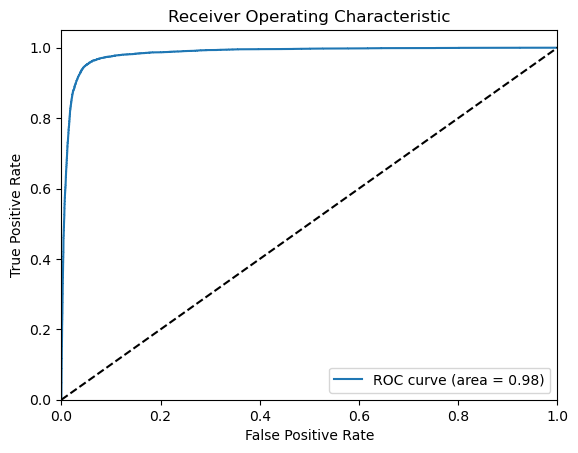

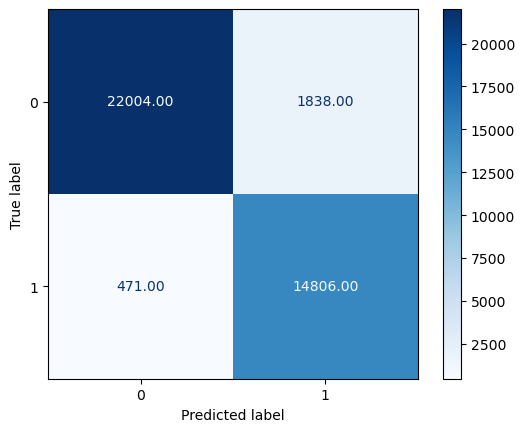

Accuracy = 0.9495385873872032
ROC Area under Curve = 0.9899590245545125
Cohen's Kappa = 0.8956808033658658
Time taken = 7.951955318450928
              precision    recall  f1-score   support

           0    0.98665   0.92979   0.95737     23842
           1    0.89947   0.98036   0.93817     15277

    accuracy                        0.94954     39119
   macro avg    0.94306   0.95508   0.94777     39119
weighted avg    0.95260   0.94954   0.94988     39119



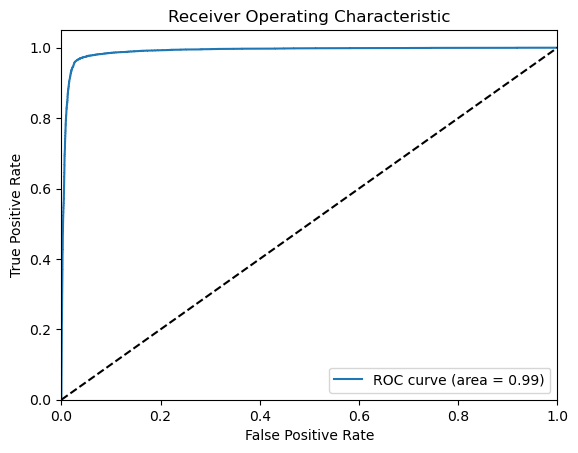

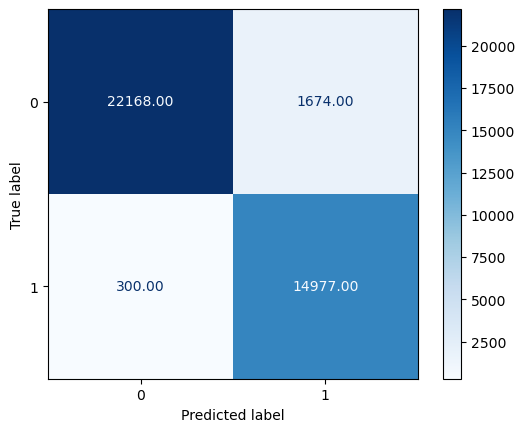

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

# Light GBM
params_lgb = {'colsample_bytree': 0.95, 
              'max_depth': 16, 
              'min_split_gain': 0.1, 
              'n_estimators': 200, 
              'num_leaves': 50, 
              'reg_alpha': 1.2, 
              'reg_lambda': 1.2, 
              'subsample': 0.95, 
              'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

# Catboost
params_cb = {'iterations': 50,
             'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

params_xgb = {'n_estimators': 500,
              'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)


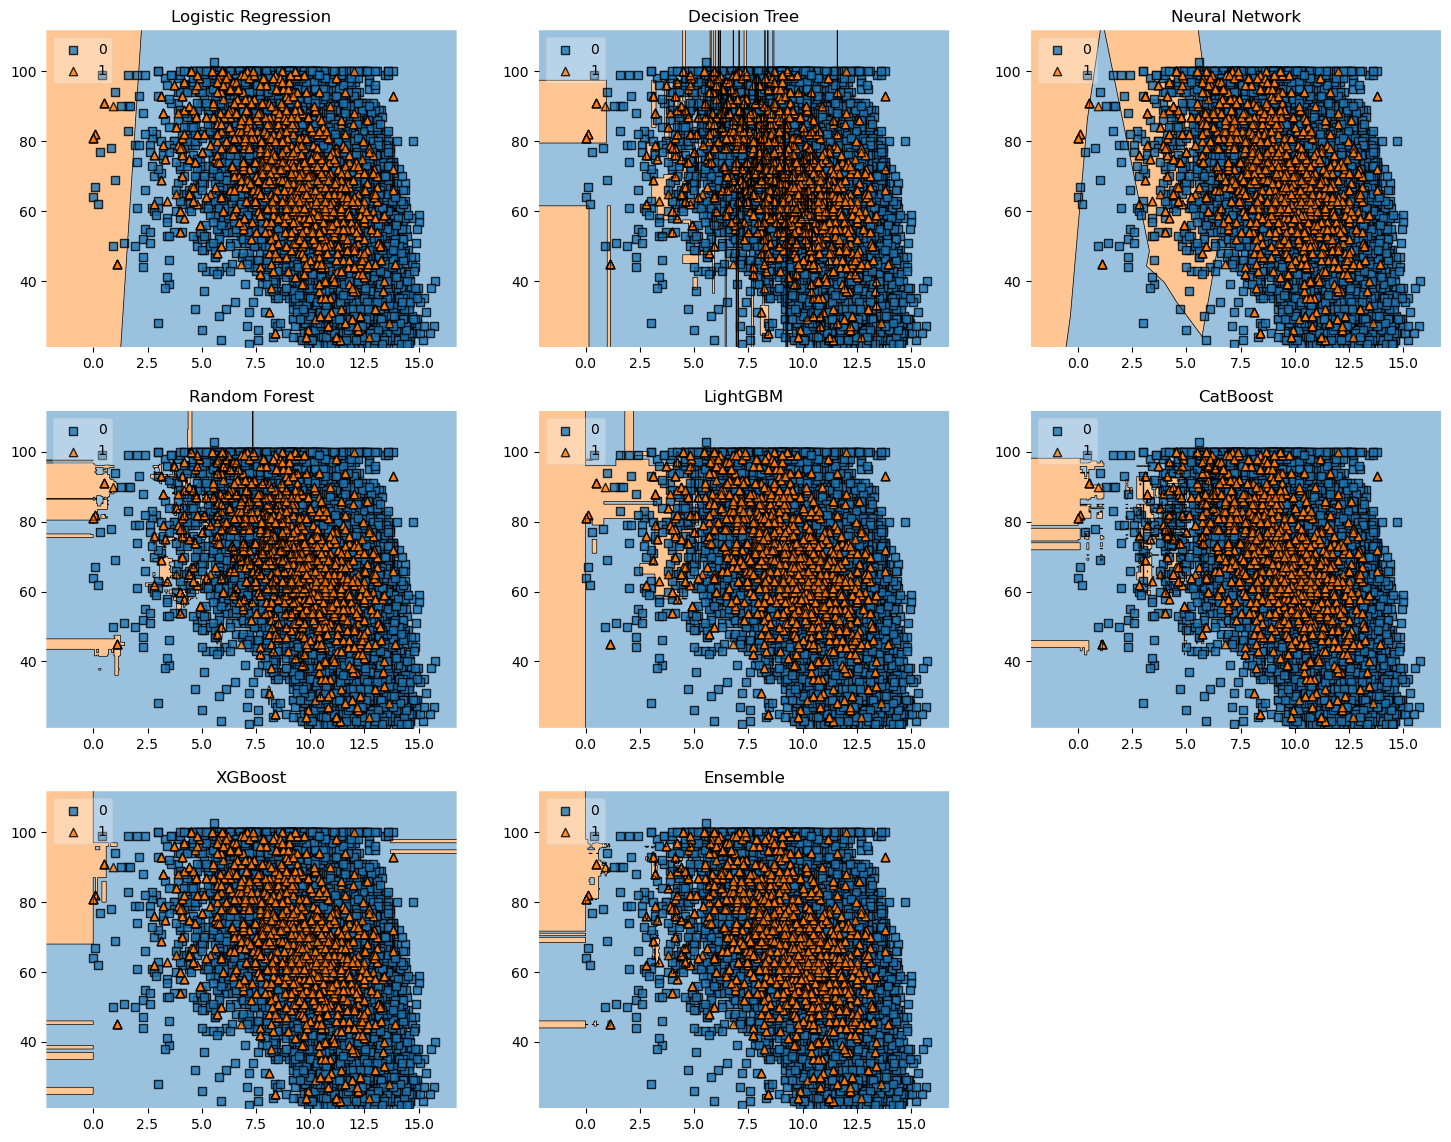

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

value = 1.80
width = 0.90

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345) 
clf3 = RandomForestClassifier(random_state=12345)
clf4 = lgb.LGBMClassifier(random_state=12345, verbose = 0)
clf5 = cb.CatBoostClassifier(random_state=12345, verbose = 0)
clf6 = xgb.XGBClassifier(random_state=12345)
eclf = EnsembleVoteClassifier(clfs=[clf4, clf5, clf6, clf7], weights=[1, 1, 1, 1], voting='soft')

X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]] #took only really important features
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression',
          'Decision Tree',
          'Random Forest',
          'LightGBM',
          'CatBoost',
          'XGBoost',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6, eclf],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, 
                                filler_feature_values={2: value}, 
                                filler_feature_ranges={2: width}, 
                                legend=2)
    plt.title(lab)

plt.show()

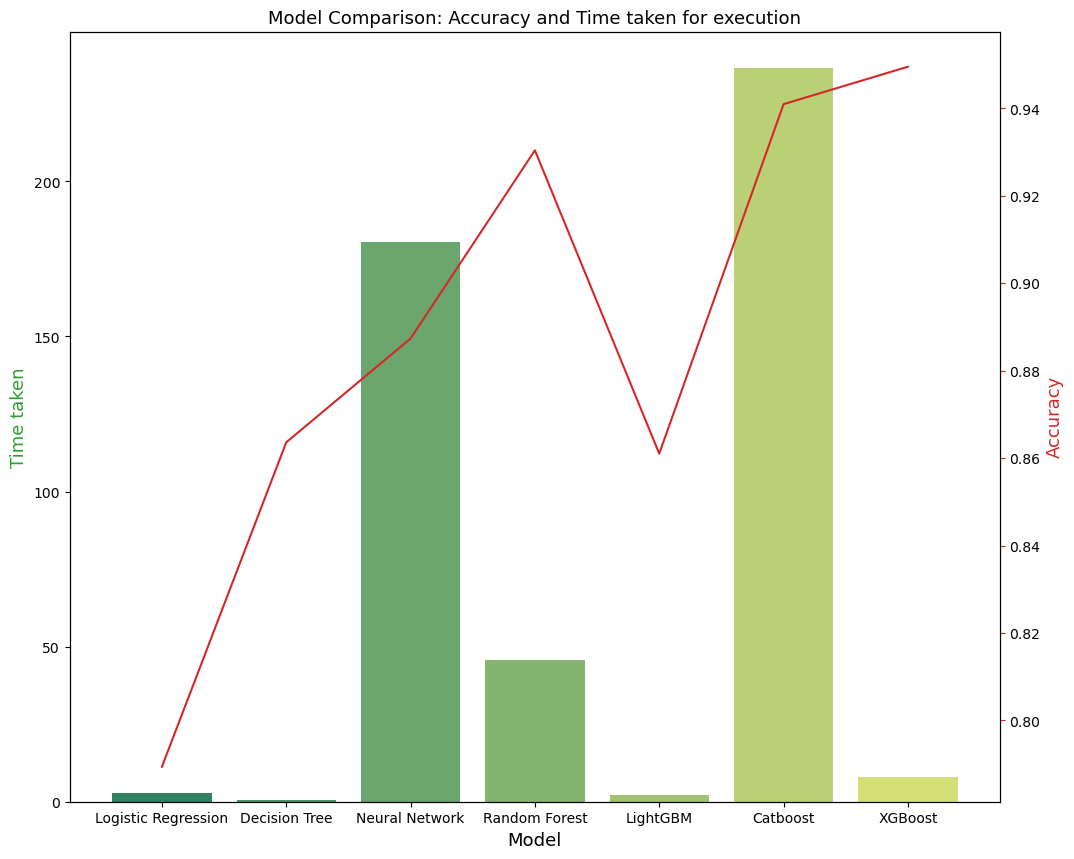

In [ ]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_lgb, accuracy_cb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_lgb, coh_kap_cb, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_lgb, tt_cb, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Random Forest','LightGBM','Catboost','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

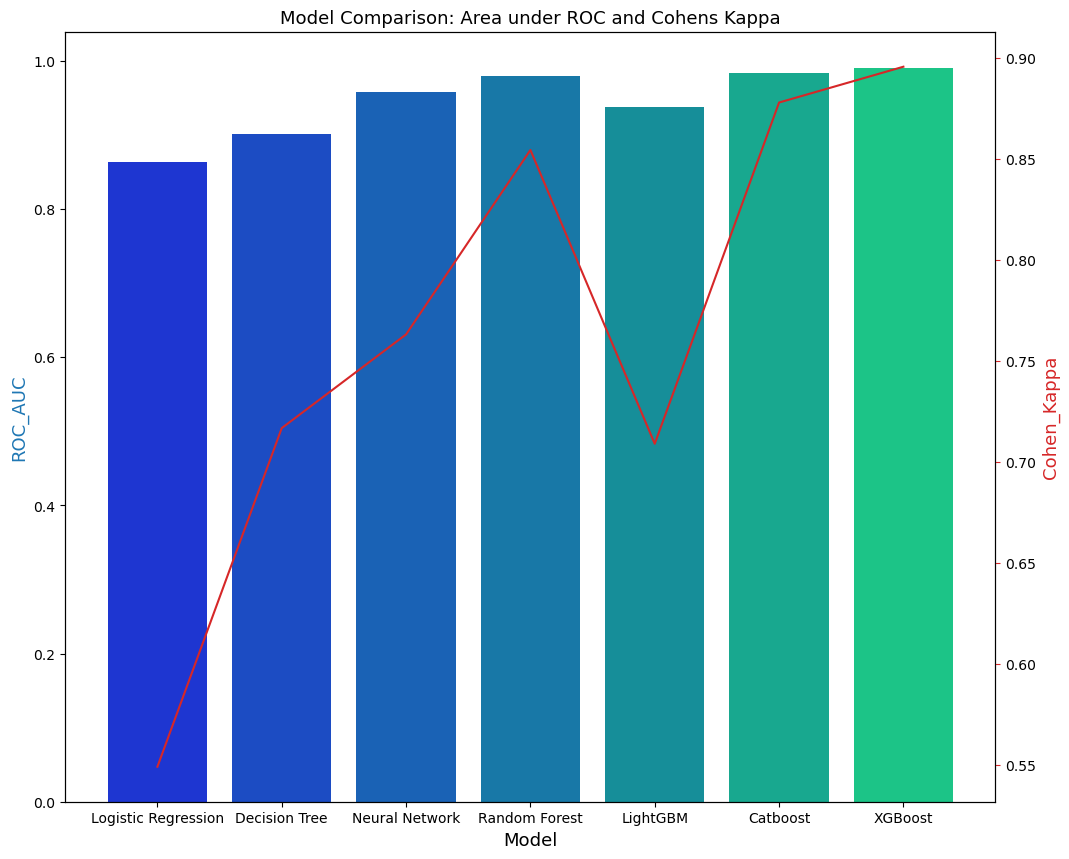

In [ ]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()